# Country Policy and Institutional Assessment (CPIA)

In [23]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [24]:
df = pd.read_csv("CPIA.csv").convert_dtypes()

# Rows and columns

In [25]:
rows, columns = df.shape
print(f"Rows: {rows}, Columns: {columns}")

Rows: 58725, Columns: 5


In [26]:
df['date'] = pd.to_datetime(df['yearmon'], errors='coerce').dt.date
df = df.convert_dtypes()
df = df.set_index(['date']).sort_index()
df = df.drop(columns=['yearmon'])

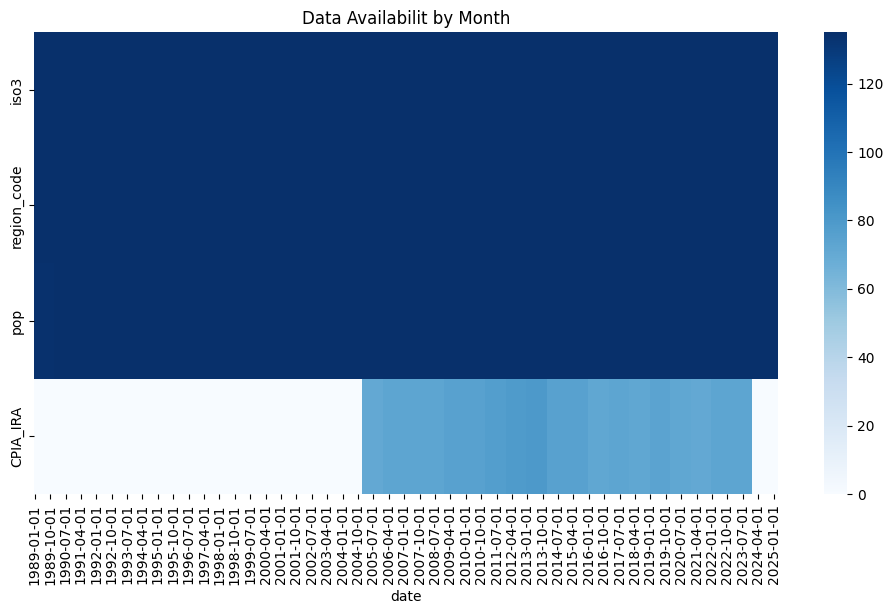

In [27]:
missing_by_month = df.groupby('date').count()
plt.figure(figsize=(12, 6))
sns.heatmap(missing_by_month.astype(float).T, cmap='Blues')
plt.title('Data Availabilit by Month')
plt.show()

### Sample data features

In [28]:
df.tail().T

date,2025-03-01,2025-03-01,2025-03-01,2025-03-01,2025-03-01
iso3,BLZ,TUV,ZMB,TUN,ZWE
region_code,LAC,EAP,SSA,MNA,SSA
pop,411106.0,9816.0,20723965.0,12200431.0,16340822.0
CPIA_IRA,<NA>,<NA>,<NA>,<NA>,<NA>


### Data structure, data types, and non-null counts

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58725 entries, 1989-01-01 to 2025-03-01
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   iso3         58725 non-null  string 
 1   region_code  58725 non-null  string 
 2   pop          58713 non-null  Float64
 3   CPIA_IRA     16872 non-null  Float64
dtypes: Float64(2), string(2)
memory usage: 2.4+ MB


### Descriptive statistics of categorical columns

In [30]:
df.describe(include='string').T

,count,unique,top,freq
iso3,58725,135,AFG,435
region_code,58725,6,SSA,20445


### Descriptive statistics of numerical columns

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pop,58713.0,41259533.486332,153319719.021372,8662.0,2108617.0,8303151.0,25698326.0,1438069596.0
CPIA_IRA,16872.0,3.24351,0.49263,1.4,2.966667,3.3,3.60833,4.441667


### Details of missing values

In [32]:
# Step 1: Create missing summary
total_rows = len(df)
missing_count = df.isnull().sum()
missing_percent = (missing_count / total_rows * 100).round(2)

missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percentage (%)': missing_percent
}).sort_values(by='Missing Percentage (%)', ascending=False)

# Step 2: Drop columns with >70% overall missing AND >20% missing in last 5 years of the data
for col in missing_df.index:
    if missing_percent[col] > 70:
        if 'date' in df.columns and pd.api.types.is_datetime64_any_dtype(df['date']):
            max_date = df['date'].max()
            five_years_ago = max_date - pd.DateOffset(years=5)
            recent_df = df[df['date'] >= five_years_ago]
            recent_missing = recent_df[col].isnull().sum()
            recent_total = recent_df[col].shape[0]
            if recent_total == 0 or (recent_missing / recent_total * 100) > 20:
                df = df.drop(columns=[col])
        else:
            df = df.drop(columns=[col])  # Drop if no date context

# Step 3: Extract clean numeric data
numeric_df = df.select_dtypes(include=['number'])
numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
numeric_df = numeric_df.dropna(axis=1, how='all')  # Drop all-NaN columns
numeric_df = numeric_df.dropna(axis=0, how='any')  # Drop rows with any NaN



In [33]:
missing_by_iso3 = df.groupby('iso3').count()
missing_by_month = df.groupby('date').count()

In [34]:
#Correlation Matrix
correlation_matrix_df = numeric_df.corr(method='pearson')

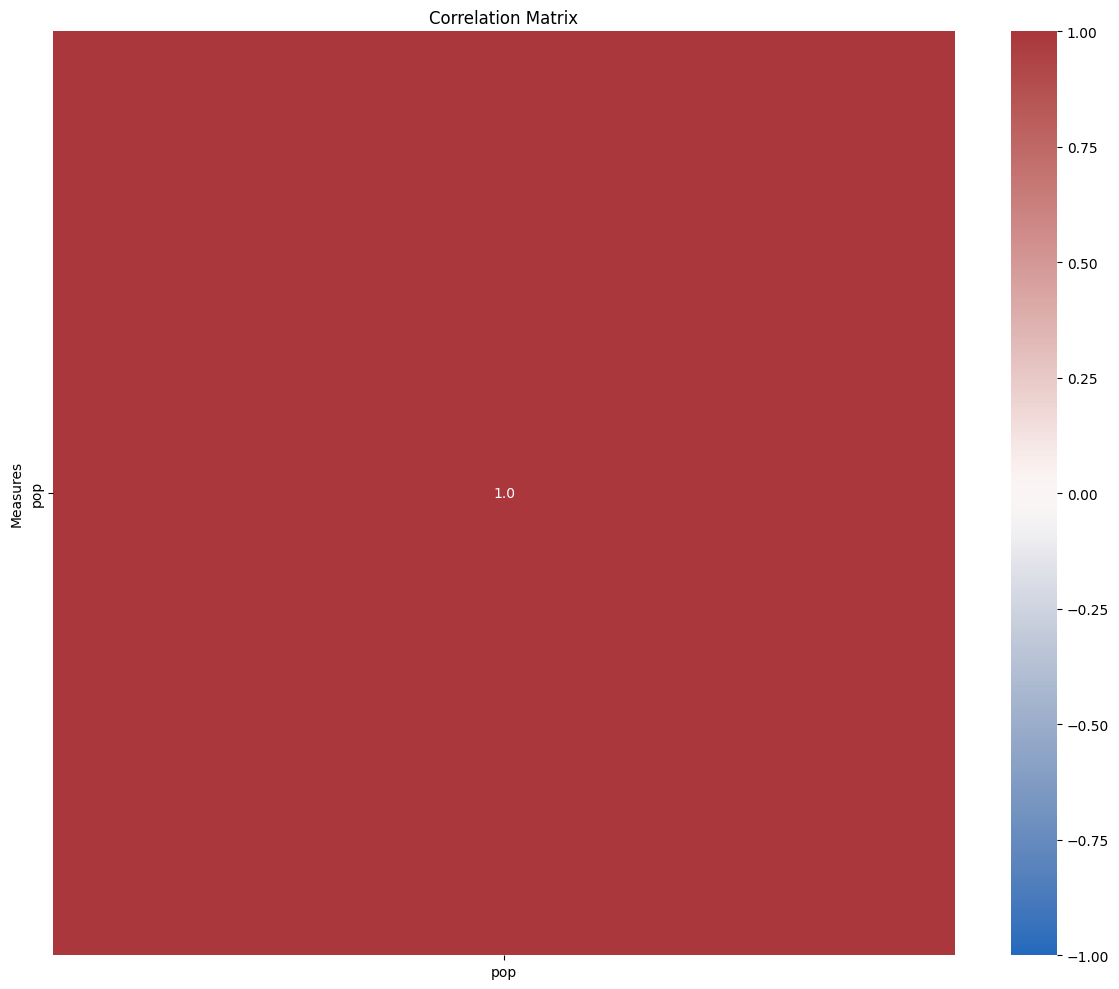

In [35]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
plt.title('Correlation Matrix')
plt.ylabel('Measures')
plt.tight_layout()
plt.show()


In [36]:
# Extract upper triangle of correlation matrix without the diagonal
corr_matrix = correlation_matrix_df.copy()
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
filtered_corr = corr_matrix.where(mask)

# Stack and filter for |correlation| > 0.5
tidy_corr = (
    filtered_corr.stack()
    .reset_index()
    .rename(columns={'level_0': 'Variable 1', 'level_1': 'Variable 2', 0: 'Correlation'})
)
tidy_corr = tidy_corr[(tidy_corr['Correlation'] > 0.5) | (tidy_corr['Correlation'] < -0.5)]
if not tidy_corr.empty:
    tidy_corr.to_excel("ACAPS_correlations_filtered.xlsx", index=False)
    print("✅ Correlation pairs saved to ACAPS_correlations_filtered.xlsx")
else:
    print("⚠️ No correlation pairs above 0.5 or below -0.5 were found.")

# Add source column
source='CPIA'
tidy_corr.insert(0, 'Source', source)

# Save to Excel
tidy_corr.to_excel(f"{source}_correlations_filtered.xlsx", index=False)

print(f"✅ Correlation pairs saved to {source}_correlations_filtered.xlsx")



⚠️ No correlation pairs above 0.5 or below -0.5 were found.
✅ Correlation pairs saved to CPIA_correlations_filtered.xlsx


In [37]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)
pca = PCA(n_components=0.75)
X_pca = pca.fit_transform(X_scaled)
n_components = X_pca.shape[1]
print(f"Number of components retained: {n_components}")
columns = [f'PC{i+1}' for i in range(n_components)]
print(f"Column names for PCA components: {columns}")

Number of components retained: 1
Column names for PCA components: ['PC1']


In [38]:
pca_df = pd.DataFrame(X_pca, index=numeric_df.index, columns=columns)
pca_correlation_matrix_df = pca_df.corr(method='pearson')

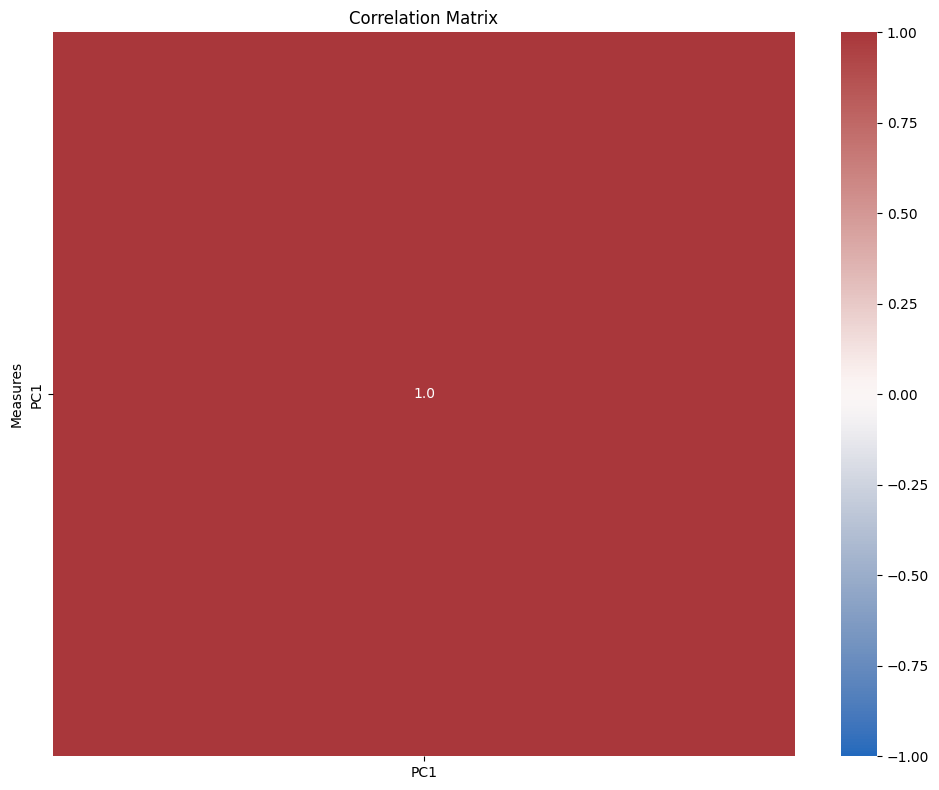

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(pca_correlation_matrix_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
plt.title('Correlation Matrix')
plt.ylabel('Measures')
plt.tight_layout()
plt.show()

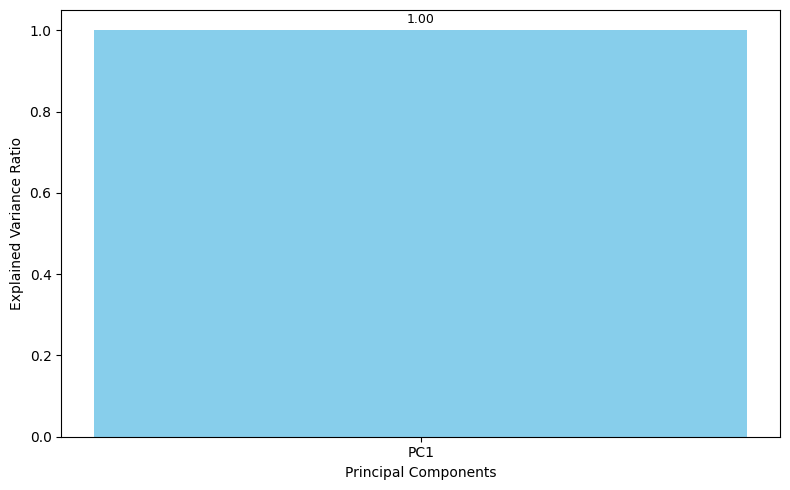

In [40]:
# Get explained variance ratios
explained_variance = pca.explained_variance_ratio_
components = np.arange(1, len(explained_variance) + 1)
labels = [f'PC{i}' for i in components]

# Plot bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(x=components, height=explained_variance, tick_label=labels, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
# plt.title('Explained Variance by Principal Component')
plt.tight_layout()
plt.show()

Cumulative explained variance at component 1: 1.0000


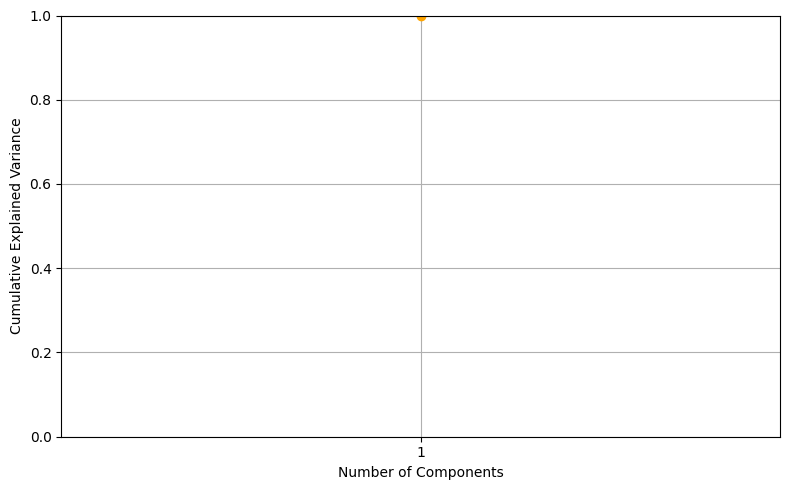

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming `pca` has already been fitted
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Specify the component number (e.g., n = 4)
n = 1 # Change this to your desired component index
if n <= len(cumulative_variance):
    print(f"Cumulative explained variance at component {n}: {cumulative_variance[n-1]:.4f}")
else:
    print(f"Component {n} exceeds the total number of components ({len(cumulative_variance)}).")

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='orange')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(np.arange(1, len(cumulative_variance) + 1, step=1))
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
feature_names = numeric_df.columns
components = pca.components_
loadings_df = pd.DataFrame(components.T, index=feature_names, columns=[f'PC{i+1}' for i in range(components.shape[0])])

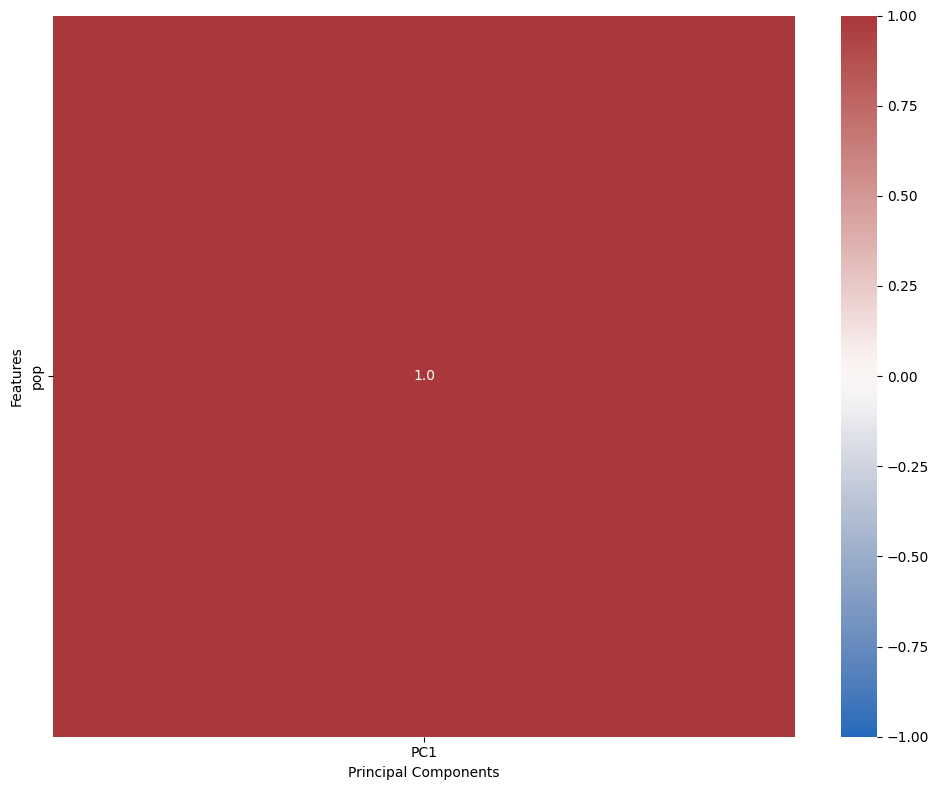

In [43]:
# create heatmap from loadings_df using sns
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, cmap='vlag', vmin=-1, vmax=1, annot=True, fmt=".1f")
# plt.title('PCA Loadings Heatmap')
plt.xlabel('Principal Components')
plt.ylabel('Features')
plt.tight_layout()
plt.show()